In [980]:
import numpy as np
import pandas as pd
from sklearn import metrics
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from keras.callbacks import EarlyStopping , ReduceLROnPlateau , ModelCheckpoint
from keras.models import load_model
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set(color_codes=True)
#sns.set_color_codes()

pd.options.display.max_rows = 15
pd.options.display.float_format = '{:,.3f}'.format

In [981]:
# network structure. 
# not to include the input layer
net_layers = (8,4,2)

epochs=200
batch_size=300

learning_rate = 1e-3
decay = learning_rate / epochs

patience=80

test_split = 0.1
validation_split = 0.2

# trials
# 11 R2-> -0.12
# 11,16,8,4 R2-> 0.37
# 11,11,6 R2-> -0.2
# 11,8,6 R2->   0.316
# 11,11,8,4 R2->  0.37
# 11, 6 R2-> 0.37

In [982]:
# 1- read data file
# 1- read processed file
file_dir = '../data/processed-data/'

data_file = 'no_missing_outliers_dataset.csv'
#data_file = 'normalized_dataset.csv'
#data_file = 'standardized_normalized_dataset.csv'
data = pd.read_csv(file_dir + data_file)

In [983]:
data.head(5)

,svc_cpu_use,svc_cpu_thr,svc_net_use,svc_disk_use,system_cpu_use,system_cpu_sat,system_net_use,system_net_sat,system_disk_sat,system_disk_io,svc_req_size,svc_resp_size,svc_pods,svc_req_rate,ltcy
0,0.310,0.110,0.106,0.001,2.030,1.261,3.206,0.000,0.980,0.010,0.002,0.012,7.000,0.980,0.110
1,0.380,0.090,0.123,0.002,2.130,1.268,3.552,0.000,0.980,0.010,0.003,0.019,7.000,1.620,0.160
2,0.370,0.100,0.131,0.002,2.100,1.179,3.586,0.000,0.980,0.010,0.003,0.024,7.000,2.180,0.220
3,0.390,0.090,0.131,0.012,2.040,1.315,3.512,0.000,0.980,0.010,0.003,0.022,6.000,2.130,0.240
4,0.370,0.100,0.140,0.018,2.020,1.385,3.449,0.000,0.980,0.010,0.003,0.023,3.000,2.220,0.250


In [984]:
data.shape

(1584, 15)

In [985]:
targets = data['ltcy']
inputs = data.drop(['ltcy'], axis=1)

n_features = inputs.values.shape[1]
print("there are {} features".format(n_features))

there are 14 features


# Feature Selection

In [986]:
if True:
    sfm = SelectFromModel(
                RandomForestRegressor(n_jobs=-1, max_depth=10, n_estimators=15),
                threshold='0.8*mean')

    selectedFeatures = sfm.fit(inputs, targets).transform(inputs)
    print('{} features selected'.format(selectedFeatures[1].shape[0]))

    feature_list = inputs.columns[sfm.get_support()]
    features = ''
    features = ', '.join(feature_list)
    
    print("columns selected are {}".format(features))

    inputs = inputs[feature_list]
    inputs.head(2)

5 features selected
columns selected are svc_cpu_thr, system_cpu_use, system_cpu_sat, system_net_use, svc_req_rate


In [987]:
n_inputs = selectedFeatures[1].shape[0]

In [988]:
x_train, x_test, y_train, y_test = \
    train_test_split(inputs, targets, test_size=test_split, shuffle=True, random_state=365)

print("y_train {} , y_test {}".format(y_train.shape, y_test.shape))

# for better convergence and result scale target to values between 0 - 1
y_train_max = y_train.max()
y_test_max = y_test.max()

y_train = y_train / y_train_max
y_test = y_test / y_test_max


y_train (1425,) , y_test (159,)


In [989]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)  # fit on training data only
x_test = scaler.transform(x_test)

## Function to build a model

In [990]:
def build_keras_model(nodes = net_layers):   # this does not work with KerasRegressor. interesting
    # create model
    model = Sequential()  
    
    if isinstance(nodes, int) or not nodes:
        model.add(Dense(1, input_dim=n_inputs, kernel_initializer='normal'))
    
    else:
        model.add(Dense(nodes[1], input_dim=n_inputs, kernel_initializer='normal', activation='relu'))
    
        layer = 0
        while layer < len(nodes):
            model.add(Dense(nodes[layer], kernel_initializer='normal', activation='relu'))
            layer = layer + 1
        
        #model.add(Dense(1, kernel_initializer='normal', activation='linear')) 
        model.add(Dense(1, kernel_initializer='normal'))  
    
    adam = Adam(lr=learning_rate, decay=decay)
    
    # or loss= 'mean_absolute_percentage_error'
    model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mse'])
    
    return model


In [991]:
model = build_keras_model()

# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)

# save the best model only
mc = ModelCheckpoint('../models/best_mlp_model.h5'
                     , monitor='val_loss'
                     , mode='min' 
                     , verbose=1
                     #, save_weights_only=True
                     , save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

callbacks = [es, mc, reduce_lr]

history = model.fit(x_train, y_train
                    , epochs=epochs
                    , batch_size=batch_size
                    , verbose=1
                    , validation_split=validation_split
                    , shuffle=False
                    , callbacks=callbacks)

print ("Done..!")


Train on 1140 samples, validate on 285 samples
Epoch 1/200
1140/1140 [==============================] - 7s 6ms/step - loss: 0.2237 - mean_squared_error: 0.2237 - val_loss: 0.2400 - val_mean_squared_error: 0.2400

Epoch 00001: val_loss improved from inf to 0.23998, saving model to ../models/best_mlp_model.h5
Epoch 2/200
1140/1140 [==============================] - 0s 22us/step - loss: 0.2202 - mean_squared_error: 0.2202 - val_loss: 0.2363 - val_mean_squared_error: 0.2363

Epoch 00002: val_loss improved from 0.23998 to 0.23633, saving model to ../models/best_mlp_model.h5
Epoch 3/200
1140/1140 [==============================] - 0s 29us/step - loss: 0.2166 - mean_squared_error: 0.2166 - val_loss: 0.2327 - val_mean_squared_error: 0.2327

Epoch 00003: val_loss improved from 0.23633 to 0.23267, saving model to ../models/best_mlp_model.h5
Epoch 4/200
1140/1140 [==============================] - 0s 29us/step - loss: 0.2131 - mean_squared_error: 0.2131 - val_loss: 0.2290 - val_mean_squared_error


Epoch 00031: val_loss improved from 0.12571 to 0.12117, saving model to ../models/best_mlp_model.h5
Epoch 32/200
1140/1140 [==============================] - 0s 21us/step - loss: 0.1059 - mean_squared_error: 0.1059 - val_loss: 0.1166 - val_mean_squared_error: 0.1166

Epoch 00032: val_loss improved from 0.12117 to 0.11660, saving model to ../models/best_mlp_model.h5
Epoch 33/200
1140/1140 [==============================] - 0s 24us/step - loss: 0.1016 - mean_squared_error: 0.1016 - val_loss: 0.1120 - val_mean_squared_error: 0.1120

Epoch 00033: val_loss improved from 0.11660 to 0.11200, saving model to ../models/best_mlp_model.h5
Epoch 34/200
1140/1140 [==============================] - 0s 26us/step - loss: 0.0973 - mean_squared_error: 0.0973 - val_loss: 0.1074 - val_mean_squared_error: 0.1074

Epoch 00034: val_loss improved from 0.11200 to 0.10739, saving model to ../models/best_mlp_model.h5
Epoch 35/200
1140/1140 [==============================] - 0s 23us/step - loss: 0.0929 - mean_sq

1140/1140 [==============================] - 0s 28us/step - loss: 0.0269 - mean_squared_error: 0.0269 - val_loss: 0.0334 - val_mean_squared_error: 0.0334

Epoch 00092: val_loss improved from 0.03345 to 0.03344, saving model to ../models/best_mlp_model.h5
Epoch 93/200
1140/1140 [==============================] - 0s 28us/step - loss: 0.0269 - mean_squared_error: 0.0269 - val_loss: 0.0334 - val_mean_squared_error: 0.0334

Epoch 00093: val_loss improved from 0.03344 to 0.03343, saving model to ../models/best_mlp_model.h5
Epoch 94/200
1140/1140 [==============================] - 0s 31us/step - loss: 0.0269 - mean_squared_error: 0.0269 - val_loss: 0.0334 - val_mean_squared_error: 0.0334

Epoch 00094: val_loss improved from 0.03343 to 0.03342, saving model to ../models/best_mlp_model.h5
Epoch 95/200
1140/1140 [==============================] - 0s 27us/step - loss: 0.0269 - mean_squared_error: 0.0269 - val_loss: 0.0334 - val_mean_squared_error: 0.0334

Epoch 00095: val_loss improved from 0.033


Epoch 00122: val_loss improved from 0.03317 to 0.03316, saving model to ../models/best_mlp_model.h5
Epoch 123/200
1140/1140 [==============================] - 0s 28us/step - loss: 0.0268 - mean_squared_error: 0.0268 - val_loss: 0.0331 - val_mean_squared_error: 0.0331

Epoch 00123: val_loss improved from 0.03316 to 0.03315, saving model to ../models/best_mlp_model.h5
Epoch 124/200
1140/1140 [==============================] - 0s 27us/step - loss: 0.0268 - mean_squared_error: 0.0268 - val_loss: 0.0331 - val_mean_squared_error: 0.0331

Epoch 00124: val_loss improved from 0.03315 to 0.03314, saving model to ../models/best_mlp_model.h5
Epoch 125/200
1140/1140 [==============================] - 0s 31us/step - loss: 0.0268 - mean_squared_error: 0.0268 - val_loss: 0.0331 - val_mean_squared_error: 0.0331

Epoch 00125: val_loss improved from 0.03314 to 0.03313, saving model to ../models/best_mlp_model.h5
Epoch 126/200
1140/1140 [==============================] - 0s 28us/step - loss: 0.0268 - mea


Epoch 00183: val_loss improved from 0.03264 to 0.03263, saving model to ../models/best_mlp_model.h5
Epoch 184/200
1140/1140 [==============================] - 0s 32us/step - loss: 0.0266 - mean_squared_error: 0.0266 - val_loss: 0.0326 - val_mean_squared_error: 0.0326

Epoch 00184: val_loss improved from 0.03263 to 0.03262, saving model to ../models/best_mlp_model.h5
Epoch 185/200
1140/1140 [==============================] - 0s 28us/step - loss: 0.0266 - mean_squared_error: 0.0266 - val_loss: 0.0326 - val_mean_squared_error: 0.0326

Epoch 00185: val_loss improved from 0.03262 to 0.03261, saving model to ../models/best_mlp_model.h5
Epoch 186/200
1140/1140 [==============================] - 0s 28us/step - loss: 0.0266 - mean_squared_error: 0.0266 - val_loss: 0.0326 - val_mean_squared_error: 0.0326

Epoch 00186: val_loss improved from 0.03261 to 0.03260, saving model to ../models/best_mlp_model.h5
Epoch 187/200
1140/1140 [==============================] - 0s 29us/step - loss: 0.0266 - mea

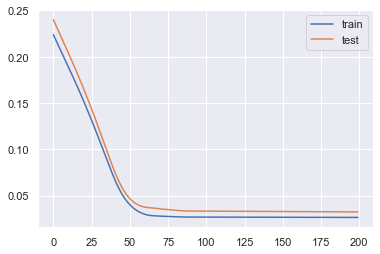

In [992]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


In [993]:
val_loss = history.history['val_loss']
val_loss_df = pd.DataFrame(val_loss)

print("Model Validation MSE mean: %.2f  std: (%.2f)" % \
      (val_loss_df.mean(), val_loss_df.std()))


Model Validation MSE mean: 0.06  std: (0.06)


In [994]:
# load the saved model
saved_model = load_model('../models/best_mlp_model.h5')

# evaluate the model
train_loss, train_mse = saved_model.evaluate(x_train, y_train, verbose=0)
test_loss, test_mse = saved_model.evaluate(x_test, y_test, verbose=0)
print('Train MSE: %.3f, Test MSE: %.3f' % (train_acc, test_acc))

Train MSE: 0.015, Test MSE: 0.012


In [995]:
#regressor.fit(x_train, y_train)
y_hat = saved_model.predict(x_train)
y_hat

array([[0.24048465],
       [0.4818709 ],
       [0.45992255],
       ...,
       [0.44531393],
       [0.41986185],
       [0.38615486]], dtype=float32)

In [996]:
r2_train = metrics.r2_score(y_train, y_hat)
print('R2 (training) = {}'.format(r2_train))

R2 (training) = 0.32585681238609954


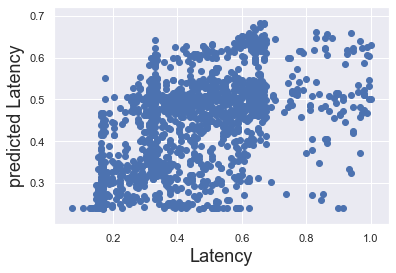

In [997]:
plt.scatter(y_train, y_hat)
plt.xlabel('Latency', size=18)
plt.ylabel("predicted Latency", size=18)
#plt.xlim(-2,3)
#plt.ylim(-3,1)
plt.show()

Text(0.5, 1.0, 'Residual PDF')

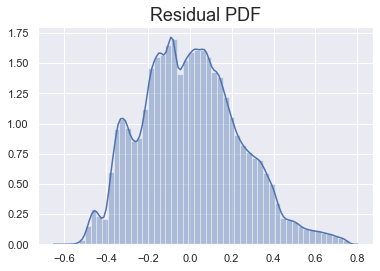

In [999]:
y_train = y_train.values
sns.distplot(y_train - y_hat)
plt.title('Residual PDF', size=18)

In [1000]:
# evaluation mean_absolute_percentage_error
train_error =  y_train - y_hat
train_error

mean_error = np.mean(train_error)
min_error = np.min(train_error)
max_error = np.max(train_error)
std_error = np.std(train_error)

print("Train Residual mean: %.2f std: %.2f  min; %.2f max: %.2f" \
      % (mean_error, std_error, min_error, max_error))

Train Residual mean: 0.00 std: 0.23  min; -0.61 max: 0.76


### Testing

In [1001]:
y_hat_test = saved_model.predict(x_test)

<function matplotlib.pyplot.show(*args, **kw)>

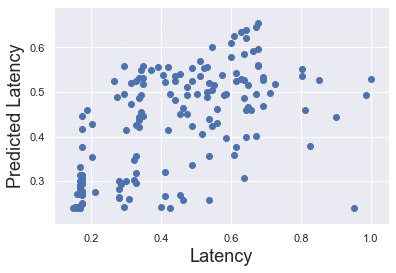

In [1002]:
plt.scatter(y_test, y_hat_test)
plt.xlabel('Latency', size=18)
plt.ylabel('Predicted Latency', size=18)
plt.show

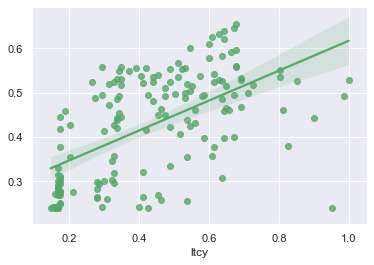

In [1003]:
ax = sns.regplot(x=y_test, y=y_hat_test, color='g')

In [1004]:
perf = pd.DataFrame(np.exp(y_hat_test), columns=['prediction'])
y_test = y_test.reset_index(drop=True)
perf['target'] = np.exp(y_test)
perf.head()

,prediction,target
0,1.627,1.399
1,1.576,1.409
2,1.349,1.323
3,1.695,1.998
4,1.731,1.449


In [1005]:
# testing mean_absolute_percentage_error
perf['residual'] = perf['prediction'] - perf['target']
perf['difference%'] = np.absolute(perf['residual'] * 100 / perf['target'])
perf

,prediction,target,residual,difference%
0,1.627,1.399,0.228,16.300
1,1.576,1.409,0.167,11.870
2,1.349,1.323,0.026,1.997
3,1.695,1.998,-0.303,15.168
4,1.731,1.449,0.283,19.516
...,...,...,...,...
154,1.908,1.957,-0.048,2.472
155,1.370,1.183,0.187,15.795
156,1.710,1.666,0.044,2.647
157,1.713,1.500,0.213,14.175


In [1006]:
perf.describe()

,prediction,target,residual,difference%
count,159.000,159.000,159.000,159.000
mean,1.544,1.583,-0.039,12.494
std,0.182,0.338,0.286,9.261
min,1.270,1.158,-1.317,0.074
25%,1.351,1.323,-0.179,5.350
50%,1.576,1.532,0.015,10.965
75%,1.692,1.831,0.146,17.183
max,1.925,2.718,0.407,50.870


In [1007]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.2f' % x)
perf.sort_values(by = ['difference%'])

,prediction,target,residual,difference%
153,1.35,1.35,0.00,0.07
81,1.59,1.59,0.00,0.21
117,1.33,1.32,0.00,0.33
144,1.90,1.90,-0.01,0.37
130,1.88,1.88,0.01,0.39
28,1.51,1.52,-0.01,0.47
132,1.57,1.58,-0.01,0.51
9,1.34,1.33,0.01,0.65
74,1.64,1.65,-0.01,0.73
88,1.84,1.82,0.02,0.84


# Prediction Accuracy

In [1008]:
r2_test = metrics.r2_score(y_test, y_hat_test)
print('R2 (testing) = {}'.format(r2_test))

R2 (testing) = 0.3347771701070098


In [1009]:
print(np.sqrt(mean_squared_error(y_test,y_hat_test)))

0.16690544873248112
